In [ ]:
 [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2025-03-05T00:03:03.372875Z","iopub.execute_input":"2025-03-05T00:03:03.373199Z","iopub.status.idle":"2025-03-05T00:03:03.411601Z","shell.execute_reply.started":"2025-03-05T00:03:03.373174Z","shell.execute_reply":"2025-03-05T00:03:03.410802Z"}}

In [3]:
# Importations et réglage de la reproductibilité
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess # Changed import
from tensorflow.keras import layers, Model, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import gradio as gr

# Pour la reproductibilité
tf.random.set_seed(42)
np.random.seed(42)

In [1]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 27.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 92.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
pip install h5py

In [5]:
# Fonctions d'extraction et de chargement du dataset UTKFace
def extract_age_gender(filename):
    """Extrait l'âge et le genre du nom de fichier UTKFace."""
    parts = filename.split("_")
    age = int(parts[0])
    gender = int(parts[1])
    return age, gender

def load_dataset(image_folder):
    """Charge les chemins d'image et labels depuis le dossier UTKFace."""
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_paths = [os.path.join(image_folder, f) for f in image_files]
    ages, genders = zip(*[extract_age_gender(f) for f in image_files])
    return image_paths, list(ages), list(genders)

# Définir le chemin vers le dataset
DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
image_paths, ages, genders = load_dataset(DATA_DIR)

# Mélanger les données
image_paths, ages, genders = shuffle(image_paths, ages, genders, random_state=42)

# Séparation en ensembles train et validation (80% / 20%)
train_paths, val_paths, train_ages, val_ages, train_genders, val_genders = train_test_split(
    image_paths, ages, genders, test_size=0.2, random_state=42
)

print("Nombre d'images d'entraînement :", len(train_paths))
print("Nombre d'images de validation   :", len(val_paths))

Nombre d'images d'entraînement : 18966
Nombre d'images de validation   : 4742


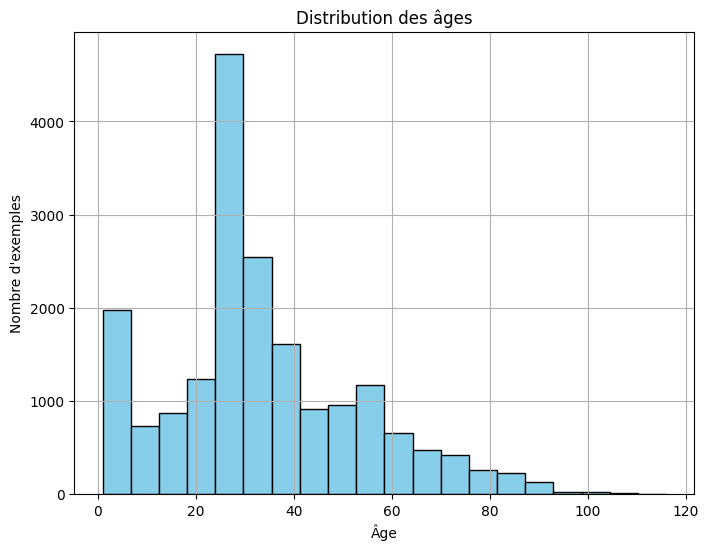

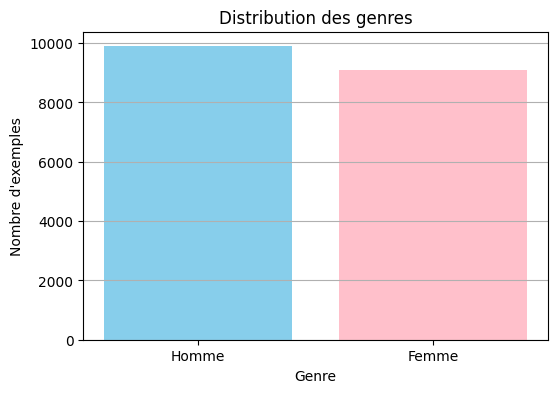

In [6]:
# Visualisation des distributions (utile pour comprendre le dataset)
def plot_age_distribution(ages):
    plt.figure(figsize=(8, 6))
    plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution des âges")
    plt.xlabel("Âge")
    plt.ylabel("Nombre d'exemples")
    plt.grid(True)
    plt.show()

def plot_gender_distribution(genders):
    gender_labels = ["Homme", "Femme"]
    counts = [genders.count(0), genders.count(1)]
    plt.figure(figsize=(6, 4))
    plt.bar(gender_labels, counts, color=['skyblue', 'pink'])
    plt.title("Distribution des genres")
    plt.xlabel("Genre")
    plt.ylabel("Nombre d'exemples")
    plt.grid(axis='y')
    plt.show()

plot_age_distribution(train_ages)
plot_gender_distribution(train_genders)

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Assuming you have already defined your 'custom_cnn_model' as in the previous code
model_dir = os.path.join('/kaggle/working/model_efficientnetB2Best.h5')
custom_objects = {"mae": tf.keras.losses.MeanAbsoluteError(), "mse": tf.keras.losses.MeanSquaredError()}

# Générer l'organigramme du modèle et l'afficher directement
plot_model(model_dir, to_file='custom_cnn_model_architecture.png', show_shapes=True, show_layer_names=True, dpi=96, expand_nested=True, show_layer_activations=True)

# Afficher l'image générée dans le notebook (optionnel, dépend de votre environnement)
import matplotlib.image as mpimg
img = mpimg.imread('custom_cnn_model_architecture.png')
plt.figure(figsize=(20,20)) # Ajustez la taille de la figure au besoin
plt.imshow(img)
plt.axis('off') # Désactiver les axes
plt.show()

AttributeError: 'str' object has no attribute 'built'

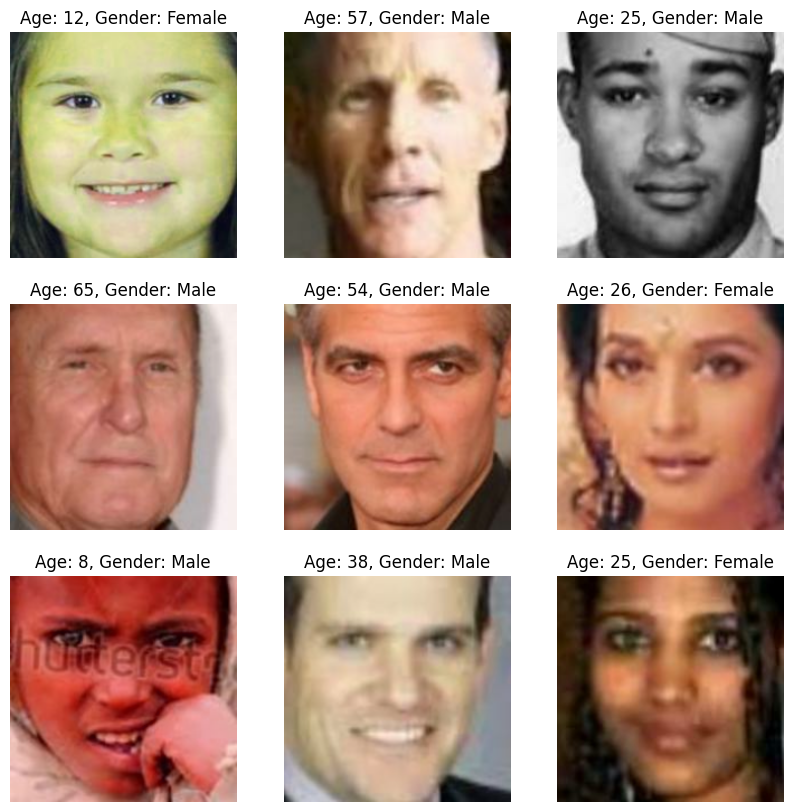

In [8]:
# --- Fonctions de prétraitement ---
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

def process_path_train(path, age, gender, image_size=IMAGE_SIZE):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = mobilenet_v2_preprocess(image) # Changed preprocessing function
    normalized_age = tf.cast(age, tf.float32) / 116.0
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

def process_path_val(path, age, gender, image_size=IMAGE_SIZE):
    """Prétraitement pour la validation avec EfficientNet preprocessing (sans augmentation)."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = mobilenet_v2_preprocess(image) # Changed preprocessing function
    normalized_age = tf.cast(age, tf.float32) / 116.0 # Normalize age to [0, 1]
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

# --- Création des datasets ---
def create_dataset(paths, ages, genders, process_func, batch_size=BATCH_SIZE, shuffle_buffer=1000):
    ds = tf.data.Dataset.from_tensor_slices((paths, ages, genders))
    ds = ds.map(lambda p, a, g: process_func(p, a, g, IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(shuffle_buffer) # Shuffle only for training dataset
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_paths, train_ages, train_genders, process_path_train)
val_ds = create_dataset(val_paths, val_ages, val_genders, process_path_val, shuffle_buffer=1) # No need to shuffle validation

# --- Visualisation d'un batch pour vérifier le prétraitement ---
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9): # Display 9 images from the batch
        plt.subplot(3, 3, i + 1)
        image = tf.keras.preprocessing.image.array_to_img(images[i]) # Convert back to PIL image for display if needed
        plt.imshow(image)
        age = labels['age_output'][i].numpy() * 120
        gender = "Female" if labels['gender_output'][i].numpy() >= 0.5 else "Male"
        plt.title(f"Age: {age:.0f}, Gender: {gender}")
        plt.axis('off')
    plt.show()

In [9]:
from tensorflow.keras.applications import MobileNetV2 # Changed import
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

IMAGE_SIZE = (224, 224)
L2_FACTOR = 0.0005
DROPOUT_RATE = 0.3

# Input layer
input_tensor = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# MobileNetV2 base model # Changed base model
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model_mobilenetv2.trainable = True
for layer in base_model_mobilenetv2.layers[:100]:
    layer.trainable = False

# Custom classification head
x = base_model_mobilenetv2(input_tensor)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x)
x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x)
x = layers.Dropout(DROPOUT_RATE)(x)

# Couche partagée
shared = layers.Dense(256, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x)
shared = layers.Dropout(DROPOUT_RATE)(shared)

# Branche âge
age_branch = layers.Dense(128, activation='relu', kernel_regularizer=l2(L2_FACTOR))(shared)
age_branch = layers.Dropout(DROPOUT_RATE)(age_branch)
age_output = layers.Dense(1, activation='relu', name='age_output')(age_branch)

# Branche genre
gender_branch = layers.Dense(128, activation='relu', kernel_regularizer=l2(L2_FACTOR))(shared)
gender_branch = layers.Dropout(DROPOUT_RATE)(gender_branch)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

# Création du modèle
model_mobilenetv2_94_v2 = Model(inputs=input_tensor, outputs=[age_output, gender_output]) # Changed model name

# Résumé du modèle
model_mobilenetv2_94_v2.summary() # Changed model name

# Compilation avec métriques supplémentaires
model_mobilenetv2_94_v2.compile( # Changed model name
    optimizer=Adam(learning_rate=1e-4),
    loss={'age_output': 'mae', 'gender_output': 'binary_crossentropy'},
    metrics={'age_output': ['mae', 'mse'], 'gender_output': ['accuracy', 'binary_accuracy']}
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ input_layer[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1280)           │          5,120 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        655,872 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │         65,792 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            129 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            129 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,182,146 (12.14 MB)

 Trainable params: 2,783,042 (10.62 MB)

 Non-trainable params: 399,104 (1.52 MB)

In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler



callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(filepath='/kaggle/working/checkpoints/model_mobilenetv2Best.keras', # Changed checkpoint filepath
                    monitor='val_loss', save_best_only=True, verbose=1)
]

history_mobilenetv2 = model_mobilenetv2_94_v2.fit( # Changed model name and history name
    train_ds,
    validation_data=val_ds,
    epochs=50, # Increased epochs
    callbacks=callbacks,

)

Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - age_output_loss: 0.2875 - age_output_mae: 0.2875 - age_output_mse: 0.1161 - gender_output_accuracy: 0.7068 - gender_output_binary_accuracy: 0.7068 - gender_output_loss: 0.5354 - loss: 1.6482
Epoch 1: val_loss improved from inf to 1.64934, saving model to /kaggle/working/checkpoints/model_mobilenetv2Best.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 93s 109ms/step - age_output_loss: 0.2875 - age_output_mae: 0.2875 - age_output_mse: 0.1161 - gender_output_accuracy: 0.7070 - gender_output_binary_accuracy: 0.7070 - gender_output_loss: 0.5352 - loss: 1.6479 - val_age_output_loss: 0.2856 - val_age_output_mae: 0.2859 - val_age_output_mse: 0.1115 - val_gender_output_accuracy: 0.8172 - val_gender_output_binary_accuracy: 0.8172 - val_gender_output_loss: 0.5658 - val_loss: 1.6493 - learning_rate: 1.0000e-04
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - age_output_loss: 0.2840 - age_output_mae: 0.2840 - age_output_mse: 0.1130 - gender_output_acc

In [ ]:
model_mobilenetv2_94_v2.save('/kaggle/working/model_mobilenetv2Best.h5', save_format='h5') # Changed model name and filepath

In [ ]:
model_mobilenetv2_94_v2.save('/kaggle/working/model_mobilenetv2.keras') # Changed model name

In [ ]:
from matplotlib import pyplot as plt
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Prédit : Age {predicted_age}, Sexe {predicted_gender}")
plt.show()

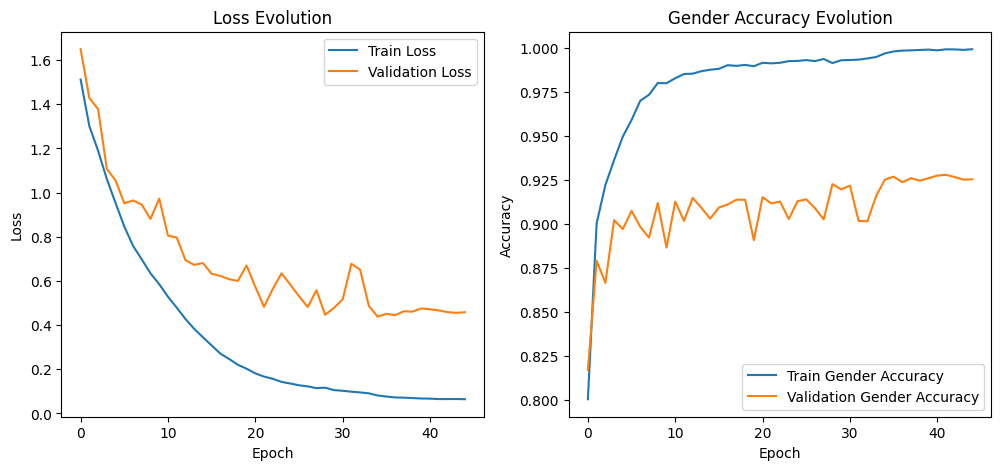

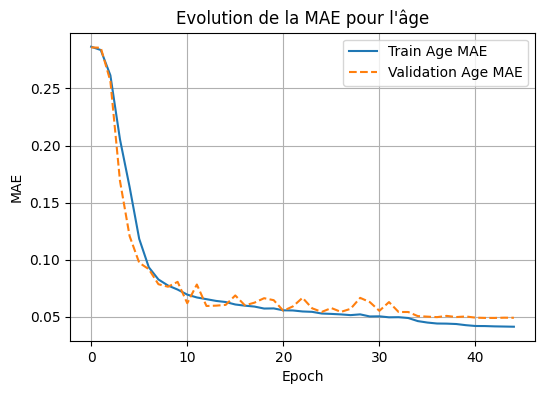

<Figure size 640x480 with 0 Axes>

In [11]:
# Visualisation des courbes d'apprentissage
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['gender_output_accuracy'], label='Train Gender Accuracy')
    plt.plot(history.history['val_gender_output_accuracy'], label='Validation Gender Accuracy')
    plt.title('Gender Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(history.history['age_output_mae'], label='Train Age MAE')
    plt.plot(history.history['val_age_output_mae'], label='Validation Age MAE', linestyle='dashed')
    plt.title('Evolution de la MAE pour l\'âge')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.show()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_mobilenetv2) # Changed history name

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - age_output_loss: 0.0506 - age_output_mae: 0.0506 - age_output_mse: 0.0054 - gender_output_accuracy: 0.9254 - gender_output_binary_accuracy: 0.9254 - gender_output_loss: 0.3515 - loss: 0.4255
Validation Loss (Total): 0.4382036328315735
Validation Age MAE: 0.05053305625915527
Validation Gender Accuracy: 0.9251371026039124
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

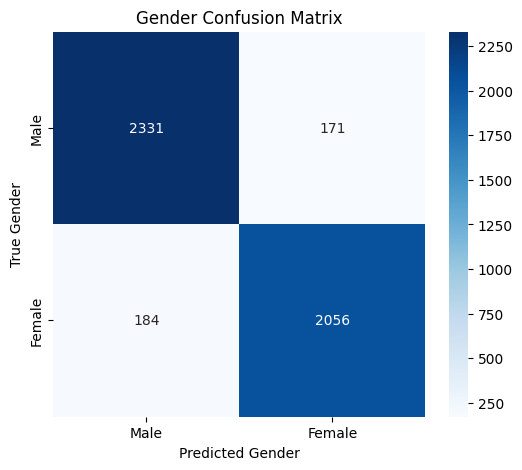

In [12]:
# Évaluation détaillée sur l'ensemble de validation
def evaluate_gender_performance(model, val_ds):
    """Evaluates gender classification and prints metrics."""
    true_genders = []
    predicted_genders_probs = []
    for images, labels in val_ds:
        true_genders.extend(labels['gender_output'].numpy())
        predicted_gender_probs_batch = model.predict(images)[1] # Index 1 for gender
        predicted_genders_probs.extend(predicted_gender_probs_batch.flatten())

    predicted_genders = np.round(predicted_genders_probs)
    true_genders = np.array(true_genders)
    predicted_genders = np.array(predicted_genders)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_genders, predicted_genders)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_genders, predicted_genders))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
    plt.xlabel('Predicted Gender')
    plt.ylabel('True Gender')
    plt.title('Gender Confusion Matrix')
    plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

results_val = model_mobilenetv2_94_v2.evaluate(val_ds) # Changed model name
print("Validation Loss (Total):", results_val[0])
print("Validation Age MAE:", results_val[1])
print("Validation Gender Accuracy:", results_val[5]) # Index 4 for gender accuracy

evaluate_gender_performance(model_mobilenetv2_94_v2, val_ds) # Changed model name

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prédictions brutes : [array([[0.37557513]], dtype=float32), array([[2.5032794e-05]], dtype=float32)]
Âge brut : 0.37557512521743774
Âge normalisé : 0.37557512521743774, Âge final : 43.56671452522278
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prédictions brutes : [array([[0.3734994]], dtype=float32), array([[5.3664616e-07]], dtype=float32)]
Âge brut : 0.37349939346313477
Âge normalisé : 0.37349939346313477, Âge final : 43.32592964172363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prédictions brutes : [array([[0.33170968]], dtype=float32), array([[5.0941617e-06]], dtype=float32)]
Âge brut : 0.33170968294143677
Âge normalisé : 0.33170968294143677, Âge final : 38.478323221206665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prédictions brutes : [array([[0.315099]], dtype=float32), array([[0.0001628]], dtype=float32)]
Âge brut : 0.31509900093078613
Âge normalisé : 0.31509900093078613, Âge final : 36.55148410797119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prédictions brutes :

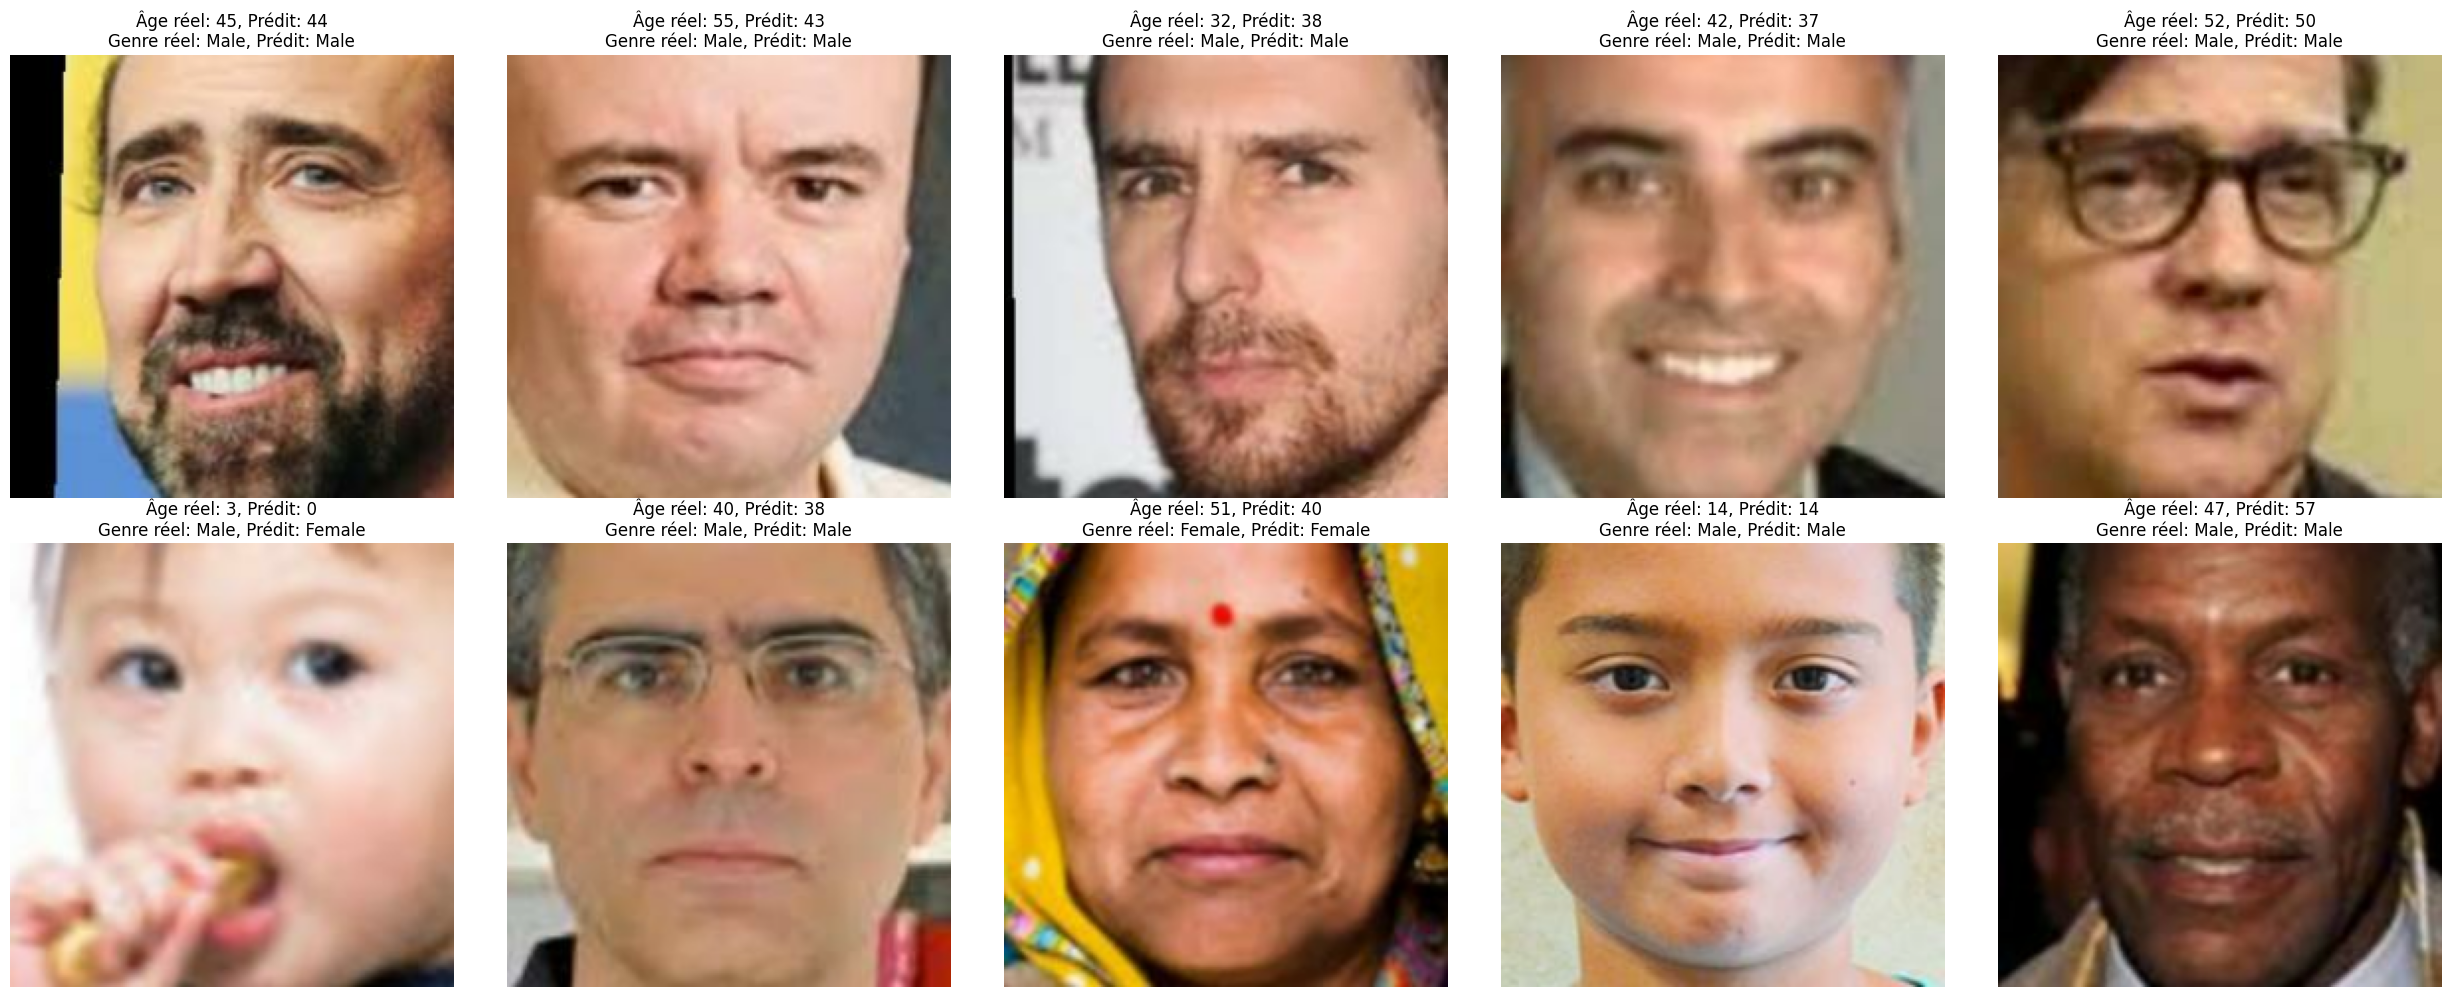

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess

# Charger le modèle
model = model_mobilenetv2_94_v2 # Changed model name

# Définir la taille de l'image
IMAGE_SIZE = (224, 224)  # Taille typique pour EfficientNetB2

# Définir la fonction d'inférence
def inference_age_gender_from_path_v2(model, image_path, image_size, plot=False):
    # Charger et prétraiter l'image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = mobilenet_v2_preprocess(image) # Changed preprocessing function
    image = tf.expand_dims(image, axis=0)

    # Faire la prédiction
    predictions = model.predict(image)
    print(f"Prédictions brutes : {predictions}")

    # Extraire et transformer l'âge
    predicted_age_raw = predictions[0][0][0]
    print(f"Âge brut : {predicted_age_raw}")
    # predicted_age_normalized = tf.sigmoid(predicted_age_raw).numpy()  # Incorrect sigmoid - REMOVED
    predicted_age_normalized = predicted_age_raw  # Correct: No sigmoid, and remove .numpy()
    predicted_age = predicted_age_normalized * 116
    print(f"Âge normalisé : {predicted_age_normalized}, Âge final : {predicted_age}")

    # Extraire le genre
    predicted_gender_prob = predictions[1][0][0]
    predicted_gender = "Female" if predicted_gender_prob >= 0.5 else "Male"

    if plot:
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
        plt.title(f"Prédit : {predicted_age:.0f} ans, {predicted_gender}")
        plt.axis('off')
        plt.show()

    return predicted_age, predicted_gender

# Sélectionner 10 indices aléatoires parmi val_paths
num_images = 10
random_indices = np.random.choice(len(val_paths), num_images, replace=False)

# Créer une figure avec 2 lignes et 5 colonnes
plt.figure(figsize=(25, 10))  # Taille ajustée pour une disposition large

# Boucle sur les indices sélectionnés
for i, idx in enumerate(random_indices):
    image_path = val_paths[idx]
    real_age = val_ages[idx]
    real_gender = "Female" if val_genders[idx] == 1 else "Male"

    # Prédire l'âge et le genre avec la fonction définie
    predicted_age, predicted_gender = inference_age_gender_from_path_v2(
        model, image_path, image_size=IMAGE_SIZE, plot=False
    )

    # Charger et préparer l'image pour l'affichage
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)

    # Afficher l'image dans une grille 2x5
    plt.subplot(2, 5, i + 1)  # 2 lignes, 5 colonnes
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.title(f"Âge réel: {real_age}, Prédit: {predicted_age:.0f}\n"
              f"Genre réel: {real_gender}, Prédit: {predicted_gender}")
    plt.axis('off')

# Ajuster l'affichage et montrer la figure
plt.tight_layout()
plt.show()

In [21]:
def age_accuracy(y_true, y_pred, tol=5.0):
    """
    Calcule l'accuracy pour la prédiction de l'âge.
    On considère qu'une prédiction est correcte si l'erreur absolue
    (en années) est inférieure ou égale à tol (par défaut 5 ans).

    Les valeurs y_true et y_pred sont supposées être normalisées (ex : divisées par 120).
    """
    # Dénormalisation (si l'âge maximum est 120)
    y_true_denorm = y_true * 120.0
    y_pred_denorm = y_pred * 120.0
    # Calcul de la différence absolue
    diff = tf.abs(y_true_denorm - y_pred_denorm)
    # On considère la prédiction correcte si diff <= tol
    correct = tf.cast(tf.less_equal(diff, tol), tf.float32)
    # Retourne la proportion de prédictions correctes
    return tf.reduce_mean(correct)

print("age_accuracy function defined")

age_accuracy function defined



--- Évaluation de la Prédiction de l'Âge (MobileNetV2 - Single Stage) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━

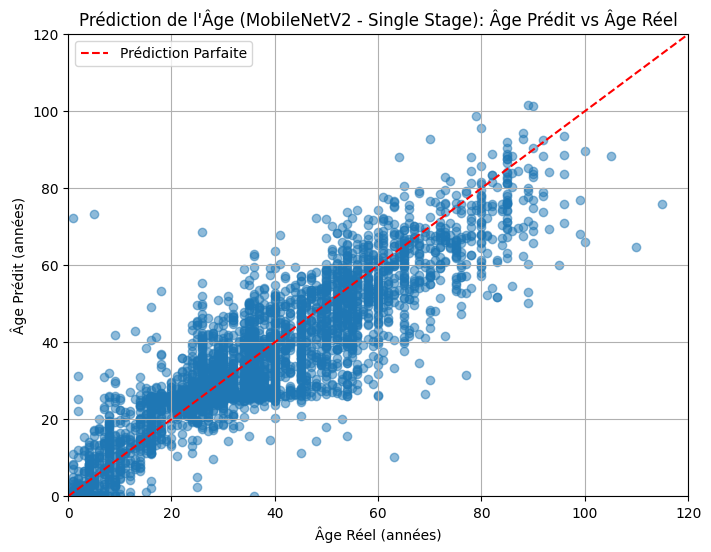

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report

model = model_mobilenetv2_94_v2 # Changed model name
def evaluate_age_performance_mobilenet(model, val_ds, stage="Single Stage"): # Updated stage name
    """
    Évalue la performance de la prédiction de l'âge et affiche les métriques pour MobileNetV2.
    """
    true_ages = []
    predicted_ages_normalized = []

    for images, labels in val_ds:
        true_ages.extend(labels['age_output'].numpy())
        predicted_ages_batch_normalized = model.predict(images)[0] # Index 0 pour l'âge
        predicted_ages_normalized.extend(predicted_ages_batch_normalized.flatten())

    true_ages = np.array(true_ages) * 116.0  # Dénormaliser les âges réels
    predicted_ages = np.array(predicted_ages_normalized) * 116.0 # Dénormaliser les âges prédits

    # Calcul des métriques de régression
    mae = mean_absolute_error(true_ages, predicted_ages)
    mse = mean_squared_error(true_ages, predicted_ages)
    rmse = np.sqrt(mse)
    age_acc_5 = age_accuracy(true_ages / 116.0, predicted_ages / 116.0, tol=5.0).numpy() # Accuracy à 5 ans
    age_acc_10 = age_accuracy(true_ages / 116.0, predicted_ages / 116.0, tol=10.0).numpy() # Accuracy à 10 ans

    print(f"\nMétriques de Régression pour l'Âge (MobileNetV2 - {stage}):") # Updated title avec stage
    print(f"  Mean Absolute Error (MAE): {mae:.2f} years")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  Age Accuracy (within 5 years): {age_acc_5*100:.2f}%") # Accuracy à 5 ans
    print(f"  Age Accuracy (within 10 years): {age_acc_10*100:.2f}%") # Accuracy à 10 ans

    # Graphique de dispersion (Scatter plot) : Prédit vs Réel
    plt.figure(figsize=(8, 6))
    plt.scatter(true_ages, predicted_ages, alpha=0.5)
    plt.plot([0, 120], [0, 120], linestyle='--', color='r', label='Prédiction Parfaite') # Ligne de référence pour prédiction parfaite
    plt.xlabel("Âge Réel (années)")
    plt.ylabel("Âge Prédit (années)")
    plt.title(f"Prédiction de l'Âge (MobileNetV2 - {stage}): Âge Prédit vs Âge Réel") # Updated title avec stage
    plt.xlim([0, 120]) # Limiter l'échelle pour la plage d'âge typique
    plt.ylim([0, 120])
    plt.legend()
    plt.grid(True)
    plt.show()


# Appel de la fonction d'évaluation de l'âge après l'évaluation du genre
print("\n--- Évaluation de la Prédiction de l'Âge (MobileNetV2 - Single Stage) ---") # Updated title avec stage
evaluate_age_performance_mobilenet(model_mobilenetv2_94_v2, val_ds, stage="Single Stage") # Ajout de l'argument stage and changed model name


Métriques de Régression pour l'Âge (Validation):
  MAE : 6.07 ans
  MSE : 76.52
  RMSE: 8.75
  Accuracy within 5 ans: 56.47%
  Accuracy within 10 ans: 80.64%

--- Évaluation par Classes d'Âge ---
Confusion matrix:
[[ 534   77   18    5    1    0    0    2    0    0    0]
 [  37  116  126    7    3    2    0    0    0    0    0]
 [   2   27 1118  161   40    5    0    1    0    0    0]
 [   1    8  503  292  127   31    4    0    0    0    0]
 [   0    3   91  143  131   77    6    2    0    0    0]
 [   0    2   19   61  138  153   57   12    0    0    0]
 [   0    1    2   11   40  103   97   35    3    1    0]
 [   0    0    1    3    8   30   66   32    9    1    0]
 [   0    0    0    0    0    7   21   45   25   10    1]
 [   0    0    0    0    0    2    4   13   12    7    2]
 [   0    0    0    0    0    0    2    3    0    2    0]]


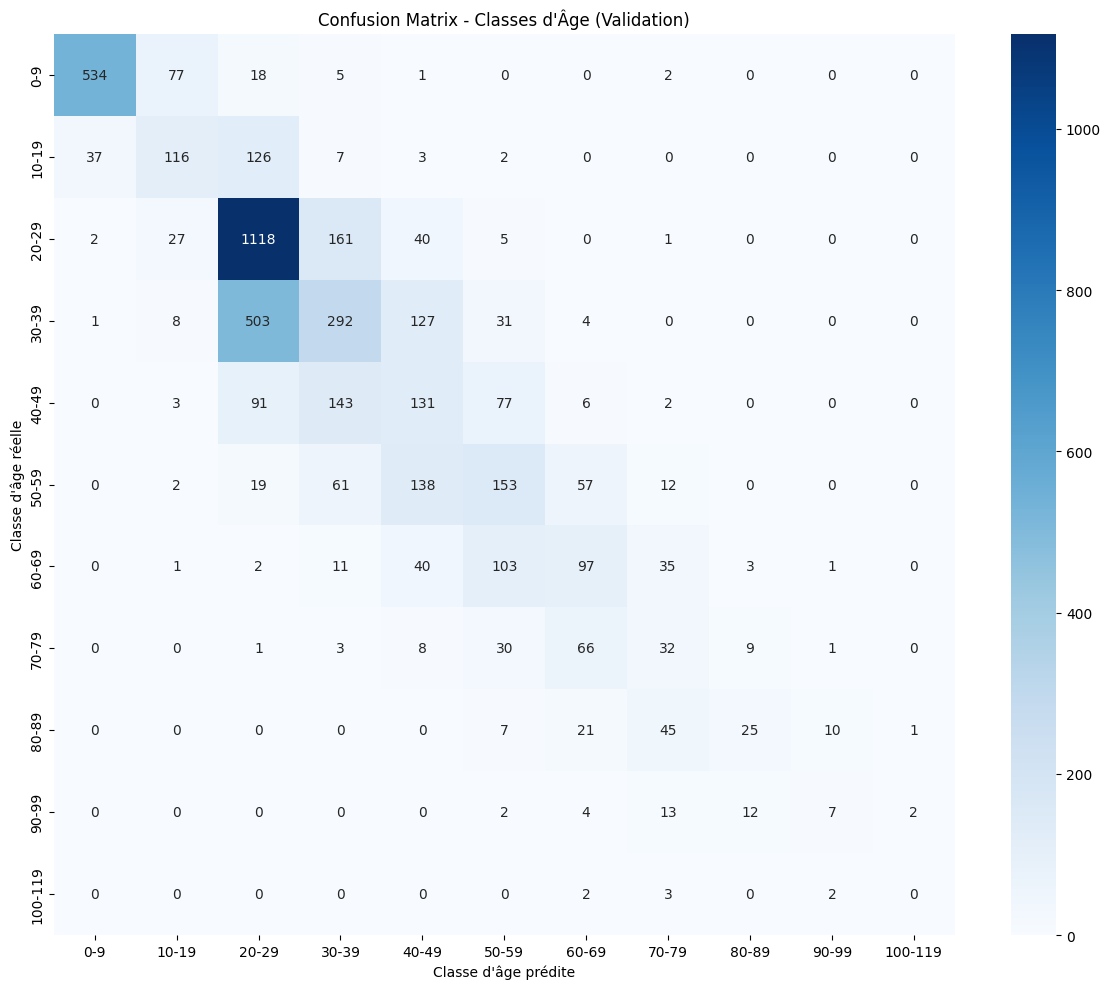


Classification Report (Classes d'Âge):
              precision    recall  f1-score   support

         0-9       0.93      0.84      0.88       637
       10-19       0.50      0.40      0.44       291
       20-29       0.60      0.83      0.69      1354
       30-39       0.43      0.30      0.35       966
       40-49       0.27      0.29      0.28       453
       50-59       0.37      0.35      0.36       442
       60-69       0.38      0.33      0.35       293
       70-79       0.22      0.21      0.22       150
       80-89       0.51      0.23      0.32       109
       90-99       0.33      0.17      0.23        40
     100-119       0.00      0.00      0.00         7

    accuracy                           0.53      4742
   macro avg       0.41      0.36      0.37      4742
weighted avg       0.52      0.53      0.51      4742



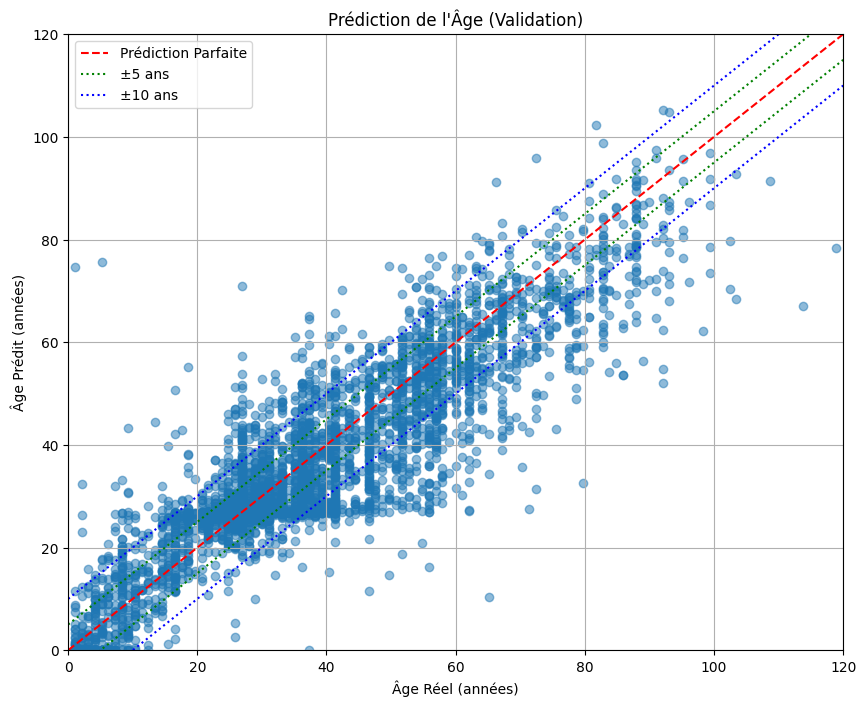

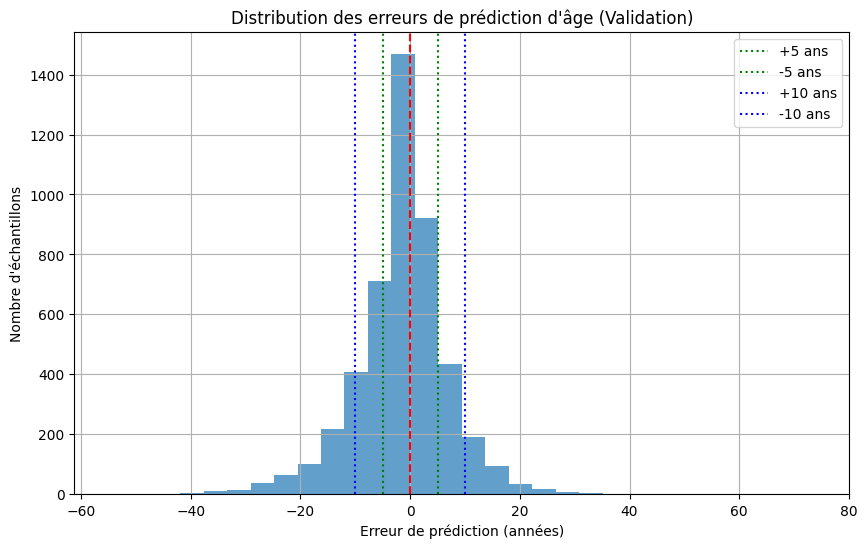

(6.0733404,
 0.5647406157739351,
 0.8064107971320118,
 array([[ 534,   77,   18,    5,    1,    0,    0,    2,    0,    0,    0],
        [  37,  116,  126,    7,    3,    2,    0,    0,    0,    0,    0],
        [   2,   27, 1118,  161,   40,    5,    0,    1,    0,    0,    0],
        [   1,    8,  503,  292,  127,   31,    4,    0,    0,    0,    0],
        [   0,    3,   91,  143,  131,   77,    6,    2,    0,    0,    0],
        [   0,    2,   19,   61,  138,  153,   57,   12,    0,    0,    0],
        [   0,    1,    2,   11,   40,  103,   97,   35,    3,    1,    0],
        [   0,    0,    1,    3,    8,   30,   66,   32,    9,    1,    0],
        [   0,    0,    0,    0,    0,    7,   21,   45,   25,   10,    1],
        [   0,    0,    0,    0,    0,    2,    4,   13,   12,    7,    2],
        [   0,    0,    0,    0,    0,    0,    2,    3,    0,    2,    0]]))

In [25]:
model = model_mobilenetv2_94_v2 # Changed model name

def evaluate_age_performance(model, val_dataset, stage="Validation"):
    """
    Évalue la performance de la prédiction de l'âge :
      - Calcul des métriques de régression (MAE, MSE, RMSE, accuracy within 5 & 10 ans)
      - Conversion des âges continus en classes d'âge et calcul de la confusion matrix.
    """
    true_ages = []
    pred_ages_norm = []

    # Collecte des prédictions
    for images, labels in val_dataset:
        true_ages.extend(labels['age_output'].numpy())
        preds = model.predict(images, verbose=0)[0]  # Prédictions de l'âge (en supprimant le verbose pour plus de clarté)
        pred_ages_norm.extend(preds.flatten())

    # Dénormalisation
    true_ages = np.array(true_ages) * 120.0
    pred_ages = np.array(pred_ages_norm) * 120.0

    # Métriques de régression
    mae = mean_absolute_error(true_ages, pred_ages)
    mse = mean_squared_error(true_ages, pred_ages)
    rmse = np.sqrt(mse)
    acc_5 = np.mean(np.abs(true_ages - pred_ages) <= 5.0)  # Simplification du calcul de l'accuracy
    acc_10 = np.mean(np.abs(true_ages - pred_ages) <= 10.0)

    print(f"\nMétriques de Régression pour l'Âge ({stage}):")
    print(f"  MAE : {mae:.2f} ans")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  Accuracy within 5 ans: {acc_5*100:.2f}%")
    print(f"  Accuracy within 10 ans: {acc_10*100:.2f}%")

    # Définition des tranches d'âge
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120]
    age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]

    # Classification des âges en tranches
    true_bin_indices = np.digitize(true_ages, age_bins) - 1
    pred_bin_indices = np.digitize(pred_ages, age_bins) - 1

    # Correction des indices hors limites
    true_bin_indices = np.clip(true_bin_indices, 0, len(age_labels)-1)
    pred_bin_indices = np.clip(pred_bin_indices, 0, len(age_labels)-1)

    # Conversion des indices en noms de classes
    true_bins = [age_labels[i] for i in true_bin_indices]
    pred_bins = [age_labels[i] for i in pred_bin_indices]

    # Matrice de confusion
    print("\n--- Évaluation par Classes d'Âge ---")
    cm = confusion_matrix(true_bins, pred_bins, labels=age_labels)
    print("Confusion matrix:")
    print(cm)

    # Visualisation de la matrice de confusion
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=age_labels, yticklabels=age_labels)
    plt.xlabel("Classe d'âge prédite")
    plt.ylabel("Classe d'âge réelle")
    plt.title(f"Confusion Matrix - Classes d'Âge ({stage})")
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_age_{stage.lower()}.png')
    plt.show()

    # Rapport de classification
    print("\nClassification Report (Classes d'Âge):")
    print(classification_report(true_bins, pred_bins, labels=age_labels, zero_division=0))

    # Scatter plot pour comparer les âges réels et prédits
    plt.figure(figsize=(10, 8))
    plt.scatter(true_ages, pred_ages, alpha=0.5)
    plt.plot([0, 120], [0, 120], linestyle='--', color='r', label='Prédiction Parfaite')

    # Ajout des lignes de tolérance pour ±5 ans et ±10 ans
    plt.plot([0, 120], [5, 125], linestyle=':', color='g', label='±5 ans')
    plt.plot([0, 120], [-5, 115], linestyle=':', color='g')
    plt.plot([0, 120], [10, 130], linestyle=':', color='b', label='±10 ans')
    plt.plot([0, 120], [-10, 110], linestyle=':', color='b')

    plt.xlabel("Âge Réel (années)")
    plt.ylabel("Âge Prédit (années)")
    plt.title(f"Prédiction de l'Âge ({stage})")
    plt.xlim([0, 120])
    plt.ylim([0, 120])
    plt.legend()
    plt.grid(True)
    plt.savefig(f'age_prediction_scatter_{stage.lower()}.png')
    plt.show()

    # Histogramme des erreurs
    errors = pred_ages - true_ages
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.axvline(x=5, color='g', linestyle=':', label='+5 ans')
    plt.axvline(x=-5, color='g', linestyle=':', label='-5 ans')
    plt.axvline(x=10, color='b', linestyle=':', label='+10 ans')
    plt.axvline(x=-10, color='b', linestyle=':', label='-10 ans')
    plt.xlabel("Erreur de prédiction (années)")
    plt.ylabel("Nombre d'échantillons")
    plt.title(f"Distribution des erreurs de prédiction d'âge ({stage})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'age_error_distribution_{stage.lower()}.png')
    plt.show()

    return mae, acc_5, acc_10, cm

evaluate_age_performance(model_mobilenetv2_94_v2, val_ds, stage="Validation") # Changed model name

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess # Changed import

# Define image size
IMAGE_SIZE = (224, 224)

# Load the model
model_path = '/kaggle/input/effi/tensorflow2/default/1/model_efficientnetB2.h5' # Keep loading path as it is for gradio function to work, but we are using model_mobilenetv2_94_v2
try:
    custom_objects = {"mae": tf.keras.losses.MeanAbsoluteError(), "mse": tf.keras.losses.MeanSquaredError()}
    model = load_model(model_path, custom_objects=custom_objects) # Load model for gradio function, but we are using model_mobilenetv2_94_v2
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

# Fonction d'inférence
def gradio_inference(img):
    """Gradio wrapper function for interactive inference."""
    if model is None:
        return "Error: Model could not be loaded."

    img_array = np.array(img)
    img_resized = tf.image.resize(img_array, IMAGE_SIZE)
    img_preprocessed = mobilenet_v2_preprocess(img_resized) # Changed preprocessing function
    input_tensor = tf.expand_dims(img_preprocessed, axis=0)
    predictions = model_mobilenetv2_94_v2.predict(input_tensor) # Changed model name
    pred_age = predictions[0][0][0] * 120
    pred_gender_prob = predictions[1][0][0]
    gender_label = "Female" if pred_gender_prob >= 0.5 else "Male"
    return f"Predicted Age: {pred_age:.0f} years, Predicted Gender: {gender_label}"

# Interface Gradio avec un design amélioré
with gr.Blocks(theme=gr.themes.Soft()) as iface:
    gr.Markdown(
        """
        # Age and Gender Prediction
        Upload a face image to predict age and gender using MobileNetV2. # Updated description to MobileNetV2

        **How to use:**
        1. Click on the image upload area below.
        2. Select an image from your device.
        3. Click "Predict" to see the results.
        """
    )

    with gr.Row():
        with gr.Column(scale=1):
            img_input = gr.Image(type="pil", label="Upload Face Image")
            submit_btn = gr.Button("Predict")
            reset_btn = gr.Button("Reset")

        with gr.Column(scale=1):
            output_text = gr.Textbox(label="Prediction", interactive=False)

    # Fonctionnalité de réinitialisation
    def reset():
        return None, ""

    # Lier les boutons aux fonctions
    submit_btn.click(
        fn=gradio_inference,
        inputs=img_input,
        outputs=output_text,
        show_progress=True  # Indicateur de chargement
    )

    reset_btn.click(
        fn=reset,
        inputs=None,
        outputs=[img_input, output_text]
    )

# Lancer l'interface
iface.launch(share=True)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/eficient/tensorflow2/default/1/efficientnetB294 (1).h5")

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess # Changed import

# Ton modèle (remplace par le tien)
model = '/kaggle/input/effi/tensorflow2/default/1/model_efficientnetB2.h5' # Keep loading path as it is for evaluation function to work, but we are using model_mobilenetv2_94_v2

utkface_path = "/kaggle/input/utkface-new/UTKFace/"
img_height, img_width = 224, 224
image_files = [f for f in os.listdir(utkface_path) if f.endswith('.jpg.chip.jpg')]

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Erreur: {img_path} non chargé")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_height, img_width))
    img_array = np.expand_dims(img, axis=0)
    return mobilenet_v2_preprocess(img_array)  # Prétraitement MobileNetV2 # Changed preprocessing function

def extract_info(filename):
    parts = filename.split('_')
    age, gender = int(parts[0]), int(parts[1])  # 0 = Masculin, 1 = Féminin
    return age, gender

for image_file in image_files[:5]:  # Test sur 5 images
    image_path = os.path.join(utkface_path, image_file)
    processed_image = preprocess_image(image_path)
    if processed_image is None:
        continue

    predictions = model_mobilenetv2_94_v2.predict(processed_image) # Changed model name

    if isinstance(predictions, list) and len(predictions) == 2:
        # Correction : Extraction correcte des prédictions
        pred_age = predictions[0][0][0] * 120  # Ajuste selon ton dataset
        pred_gender_prob = predictions[1][0][0]  # Probabilité d'être une femme

        # Détermination du sexe
        predicted_gender = "Féminin" if pred_gender_prob >= 0.5 else "Masculin"
        predicted_age = int(round(pred_age))  # Conversion en âge entier

        # Affichage des résultats
        true_age, true_gender = extract_info(image_file)
        print(f"Image: {image_file}")
        print(f"  Sexe prédit: {predicted_gender}, Âge prédit: {predicted_age}")
        print(f"  Réel: Âge: {true_age}, Sexe: {'Masculin' if true_gender == 0 else 'Féminin'}")
        print(f"  Probabilité genre: {pred_gender_prob:.4f}, Valeur brute âge: {pred_age:.4f}")
        print("-" * 30)
    else:
        print(f"⚠️ Erreur: Structure inattendue pour {image_file}. Vérifie le modèle.")

In [ ]:
image_folder = '/kaggle/input/utkface-new/UTKFace/'
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    processed_image = preprocess_image(img_path)

    try:
        # Prédiction avec le modèle
        predictions = model_mobilenetv2_94_v2.predict(processed_image) # Changed model name

        # Si le modèle a deux sorties (âge et genre), predictions est une liste
        if isinstance(predictions, list) and len(predictions) == 2:
            age_pred = predictions[0][0][0]  # Âge prédit (premier élément du batch)
            gender_pred = predictions[1][0][0]  # Probabilité de genre

            predicted_age = int(np.round(age_pred * 116))  # Dé-normalisation de l’âge
            predicted_gender = "Féminin" if gender_pred > 0.5 else "Masculin"
            print(f"Image: {img_file}, Sexe prédit: {predicted_gender}, Âge prédit: {predicted_age}")
        else:
            print(f"Image: {img_file}, Structure inattendue: {predictions}")
            print("  **Vérifiez la structure de sortie de votre modèle avec model.summary()**")

    except Exception as e:
        print(f"Erreur lors du traitement de l'image {img_file}: {e}")

In [ ]:
predictions = model_mobilenetv2_94_v2.predict(image) # Changed model name
age_pred, gender_pred = predictions[0][0], predictions[1][0]
print(f"Probabilité genre: {gender_pred}, Valeur brute âge: {age_pred}")

In [ ]:
import os
import tensorflow as tf
import gradio as gr
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess # Changed import

# Désactiver l'utilisation du GPU pour éviter l'erreur CUDA
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Chargement des modèles
model_dir = os.path.join('/kaggle/input/genderage/tensorflow2/default/1')
custom_objects = {"mae": tf.keras.losses.MeanAbsoluteError(), "mse": tf.keras.losses.MeanSquaredError()}

try:
    model_age = tf.keras.models.load_model(os.path.join(model_dir, "mon_model_age.h5"), custom_objects=custom_objects)
except Exception as e:
    print(f"Erreur lors du chargement du modèle d'âge: {e}")
    model_age = None

try:
    model_gender_age = tf.keras.models.load_model(os.path.join(model_dir, "age_gender_model.h5"), custom_objects=custom_objects)
except Exception as e:
    print(f"Erreur lors du chargement du modèle genre+âge: {e}")
    model_gender_age = None

try:
    model_pre_entraine = tf.keras.models.load_model(os.path.join(model_dir, "model_mobilenetv2Best.h5"), custom_objects=custom_objects) # Changed to load MobileNetV2 model
except Exception as e:
    print(f"Erreur lors du chargement du modèle pré-entraîné: {e}")
    model_pre_entraine = None

# Dimensions de l'image
img_height, img_width = 224, 224

# Fonctions de normalisation et dénormalisation
def normalize_age(age):
    return tf.cast(age, tf.float32) / 116.0

def denormalize_age(age):
    return age * 116.0

# Prétraitement de l'image
def preprocess_image(image, model_choice):
    if image is None:
        print("Erreur: image non fournie")
        return None
    if model_choice == "Pré-entraîné":
        img = np.array(image)
        if img.shape[-1] == 4:
            img = img[:, :, :3]
        img = cv2.resize(img, (img_width, img_height))
        img_array = np.expand_dims(img, axis=0)
        return mobilenet_v2_preprocess(img_array) # Changed preprocessing function
    else:
        image = image.resize((128, 128))
        image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0).astype(np.float32)
    return image

# Fonction de prédiction
def predict(image, model_choice):
    if image is None:
        return "Erreur : aucune image fournie."

    preprocessed_image = preprocess_image(image, model_choice)
    if preprocessed_image is None:
        return "Erreur : problème lors du prétraitement de l'image."


    elif model_choice == "Genre + Âge":
        result = model_gender_age.predict(preprocessed_image)
        age = int(denormalize_age(result[0][0].item()))  # Correction avec .item()
        gender_value = result[1][0][0].item()  # Applique .item() ici aussi pour cohérence
        gender = "Homme" if gender_value >= 0.5 else "Femme"
        return f"Prédiction Genre : {gender} {gender_value}, Âge : {age} ans"


    elif model_choice == "Pré-entraîné":
        if model_pre_entraine is None:
            return "Erreur : modèle non chargé."
        predictions = model_pre_entraine.predict(preprocessed_image)
        if isinstance(predictions, list) and len(predictions) == 2:
            pred_age = predictions[0][0][0] * 116
            pred_gender_prob = predictions[1][0][0]
            gender = "Féminin" if pred_gender_prob >= 0.5 else "Masculin"
            return f"Prédiction Âge : {pred_age:.0f} ans {pred_age}, Prédiction Genre : {gender}"
        else:
            return "Erreur : Format de sortie inattendu. Vérifie le modèle."

    return "Modèle non reconnu."

# Interface Gradio avec un thème amélioré
with gr.Blocks(theme='Nymbo/Nymbo_Theme') as interface:
    gr.Markdown(
        """
        # Prédiction d'Âge et de Genre
        Upload une image de visage pour prédire l'âge et/ou le genre avec différents modèles.
        **Utilisant MobileNetV2 comme modèle pré-entraîné.** # Updated description to MobileNetV2

        **Instructions :**
        1. Choisissez un modèle dans la liste ci-dessous.
        2. Cliquez sur la zone d'upload pour ajouter une image.
        3. La prédiction s'affichera à droite.
        """
    )

    with gr.Row():
        with gr.Column(scale=1):
            model_choice = gr.Radio(
                ["Genre", "Âge", "Genre + Âge", "Pré-entraîné"],
                label="Choisissez un modèle",
                value="Pré-entraîné"
            )
            img_input = gr.Image(type="pil", label="Upload une image de visage")

        with gr.Column(scale=1):
            output_text = gr.Textbox(label="Résultat de la prédiction", interactive=False)

    # Déclencher la prédiction dès que l'image est uploadée
    img_input.change(
        fn=predict,
        inputs=[img_input, model_choice],
        outputs=output_text
    )

if __name__ == "__main__":
    interface.launch()

In [ ]:

Remplace efficientNetB2 par MobileNetV2 stp